In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime, timedelta
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [29]:
# Đọc dữ liệu từ file Excel
fact_air = pd.read_excel('DDS_AIR_5.xlsx', sheet_name='FACT_AirQuality')
dim_date = pd.read_excel('DDS_AIR_5.xlsx', sheet_name='DIM_Date')

In [30]:
# Merge dữ liệu
df = pd.merge(fact_air, dim_date, on='DateSK', how='left')

In [31]:
# Chuyển đổi Date thành datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [32]:
# Tạo series theo ngày với AQI trung bình
daily_aqi = df.groupby('Date')['AQI'].mean()


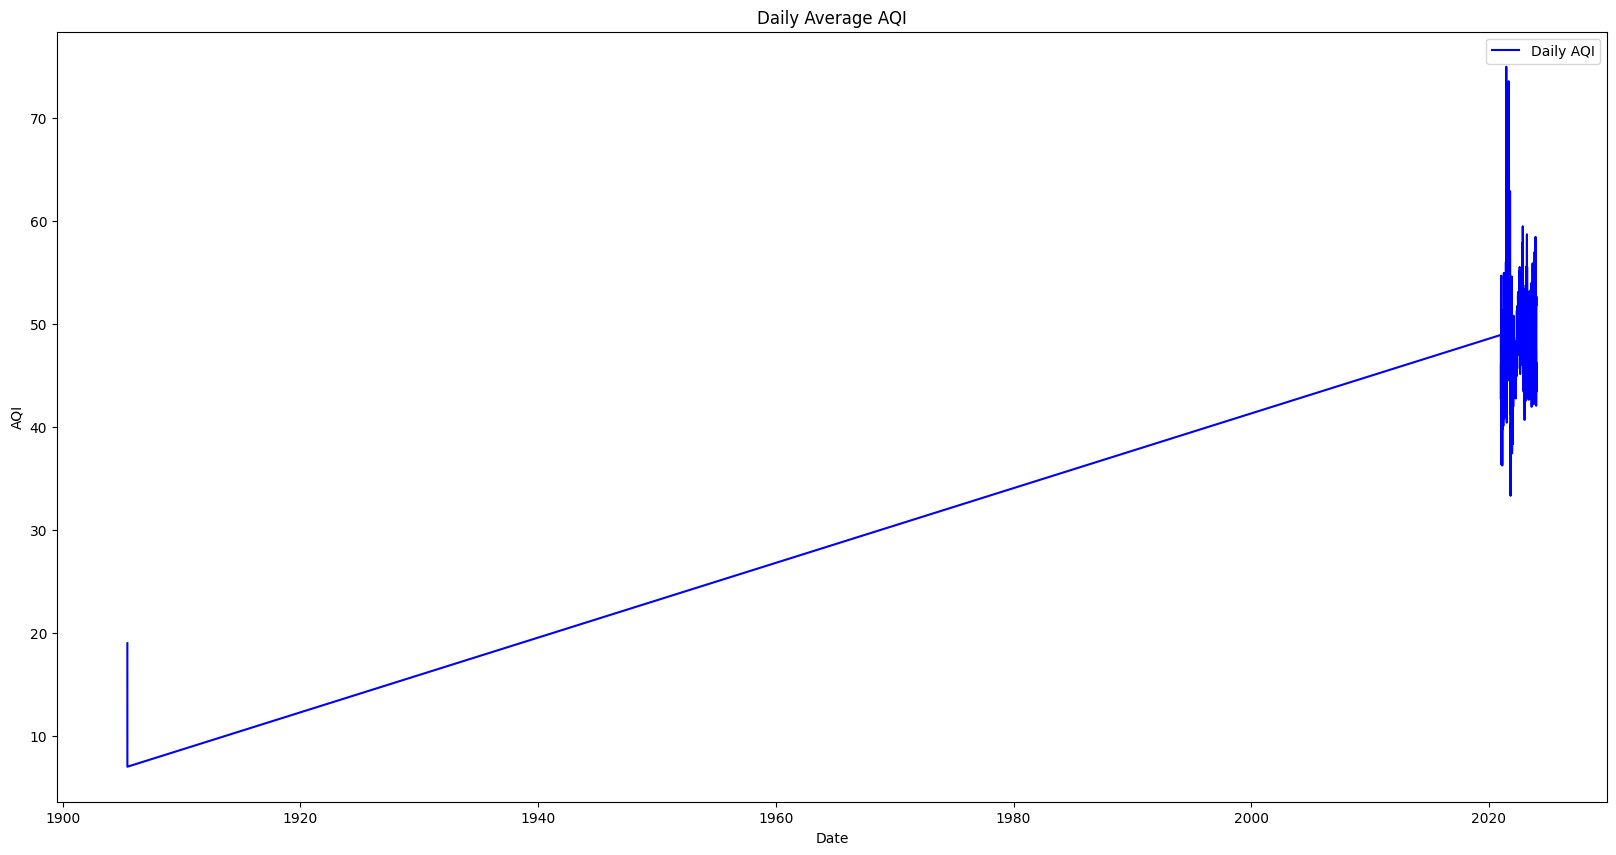

In [33]:
# 1. Vẽ biểu đồ theo ngày
plt.figure(figsize=(20, 10))
plt.plot(daily_aqi.index, daily_aqi, label='Daily AQI', color='blue')
plt.title('Daily Average AQI')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.show()

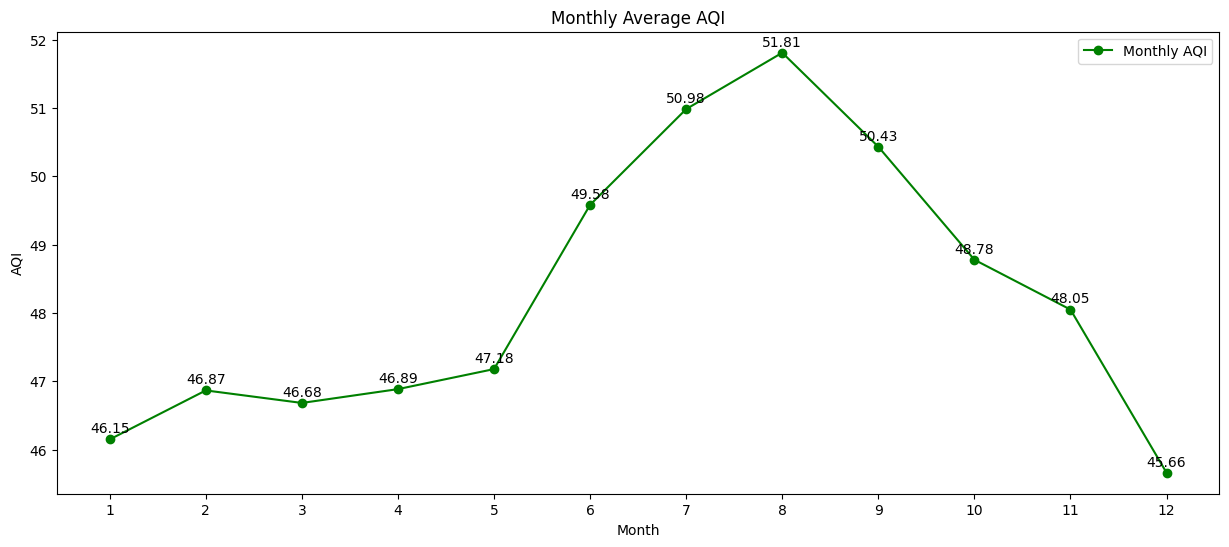

In [34]:
# 2. Vẽ biểu đồ theo tháng
monthly_aqi = df.groupby('Month')['AQI'].mean()
plt.figure(figsize=(15, 6))
plt.plot(monthly_aqi.index, monthly_aqi, label='Monthly AQI', color='green', marker='o')
plt.xticks(ticks=range(1, 13), labels=[str(i) for i in range(1, 13)])
for i, value in enumerate(monthly_aqi):
    plt.text(x=monthly_aqi.index[i], y=value + 0.1, s=f"{value:.2f}", ha='center', fontsize=10)
plt.title('Monthly Average AQI')
plt.xlabel('Month')
plt.ylabel('AQI')
plt.legend()
plt.show()


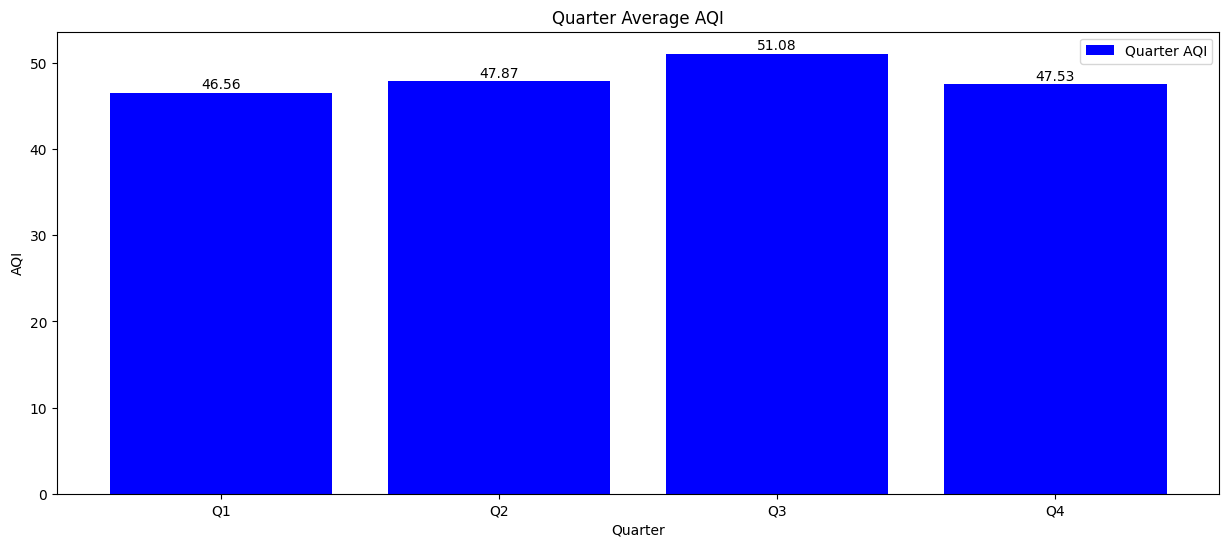

In [35]:
# 3. Vẽ biểu đồ theo quý
quarter_aqi = df.groupby('Quarter')['AQI'].mean()
plt.figure(figsize=(15, 6))
plt.bar(quarter_aqi.index, quarter_aqi, label='Quarter AQI', color='blue')
plt.xticks(ticks=range(1, 5), labels=['Q1', 'Q2', 'Q3', 'Q4'])
for i, value in enumerate(quarter_aqi):
    plt.text(x=quarter_aqi.index[i], y=value + 0.5, s=f"{value:.2f}", ha='center', fontsize=10)
plt.title('Quarter Average AQI')
plt.xlabel('Quarter')
plt.ylabel('AQI')
plt.legend()
plt.show()

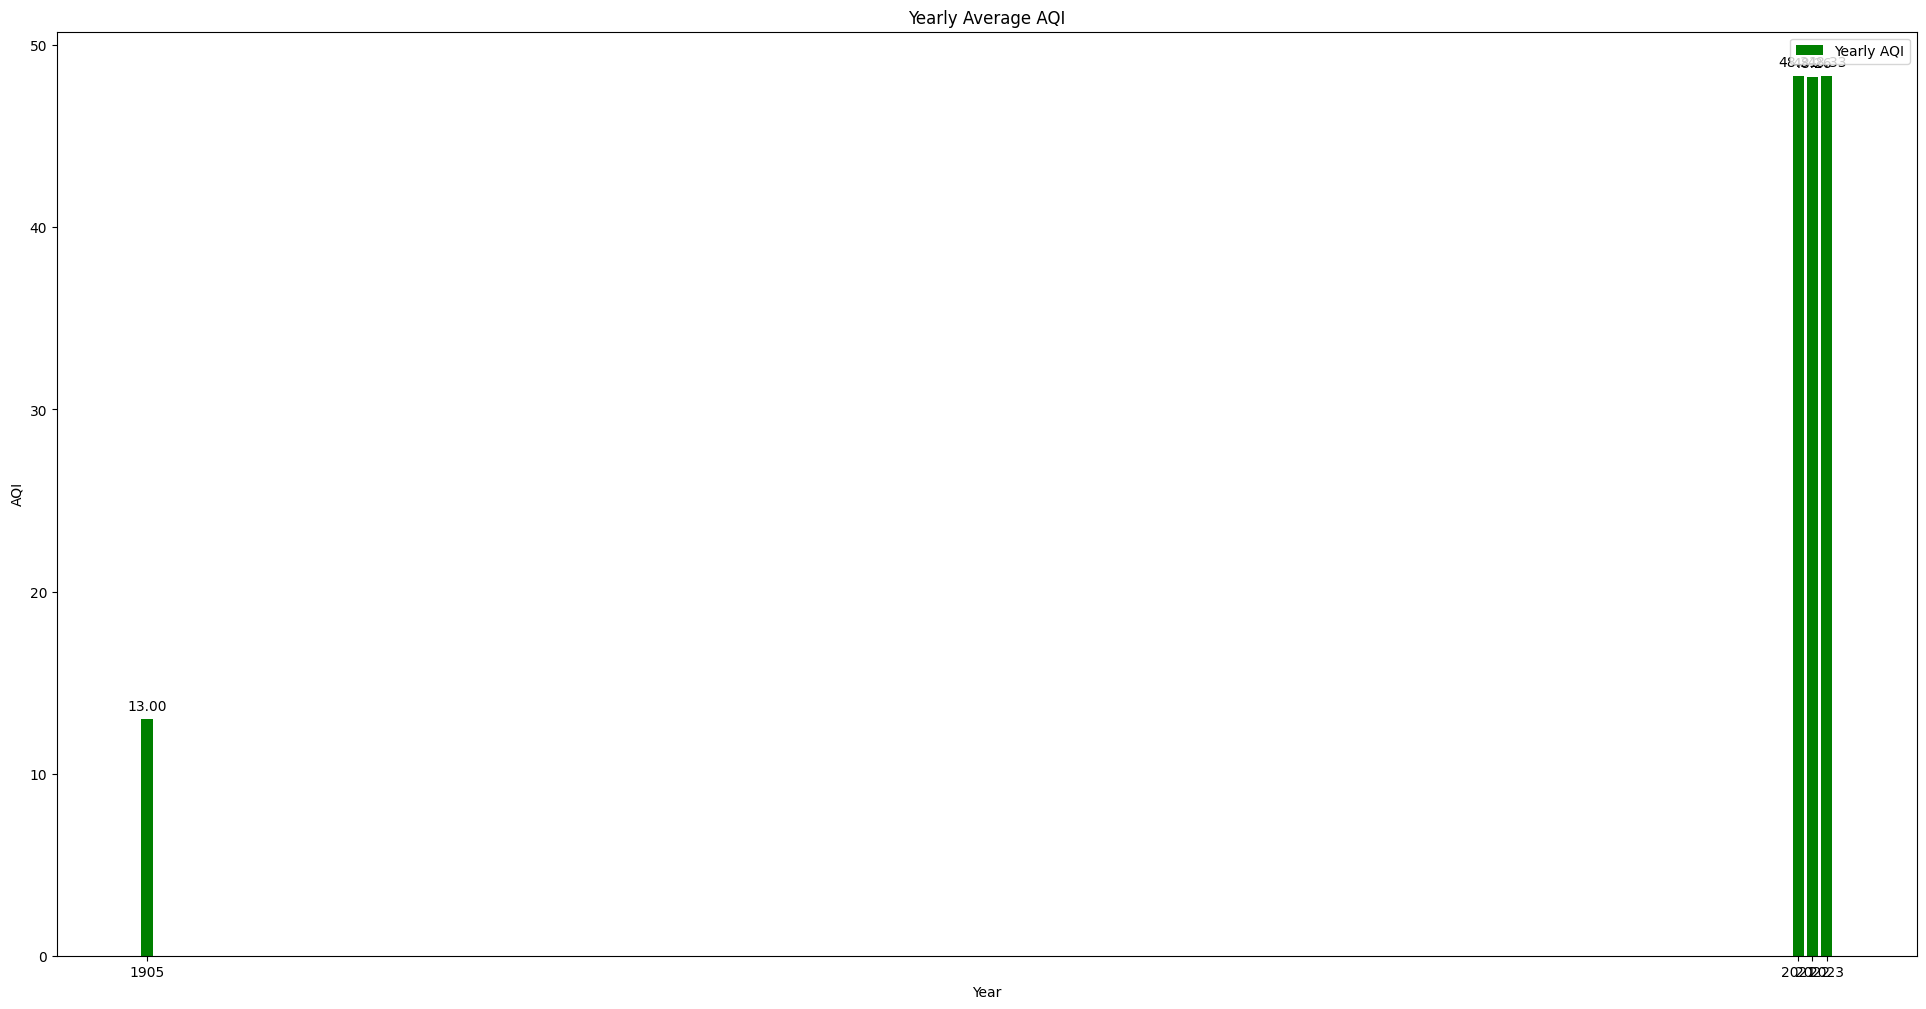

In [37]:
# 4. Vẽ biểu đồ theo năm
yearly_aqi = df.groupby('Year')['AQI'].mean()
plt.figure(figsize=(24, 12))
plt.bar(yearly_aqi.index, yearly_aqi, label='Yearly AQI', color='green')
plt.xticks(ticks=yearly_aqi.index, labels=yearly_aqi.index)
for i, value in enumerate(yearly_aqi):
    plt.text(x=yearly_aqi.index[i], y=value + 0.5, s=f"{value:.2f}", ha='center', fontsize=10)
plt.title('Yearly Average AQI')
plt.xlabel('Year')
plt.ylabel('AQI')
plt.legend()
plt.show()

In [38]:
# 5. Chuẩn bị dữ liệu cho K-means clustering
features = ['AQI', 'Month', 'Quarter']
X = df[features].copy()


In [39]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

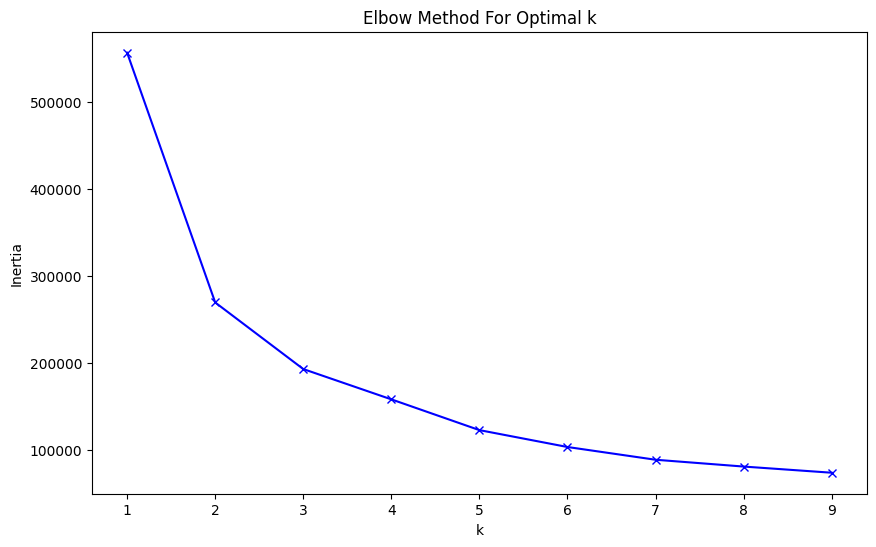

In [40]:

# 6. Tìm số cluster tối ưu bằng elbow method
inertias = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()


In [41]:
# 7. Thực hiện clustering với k=4
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

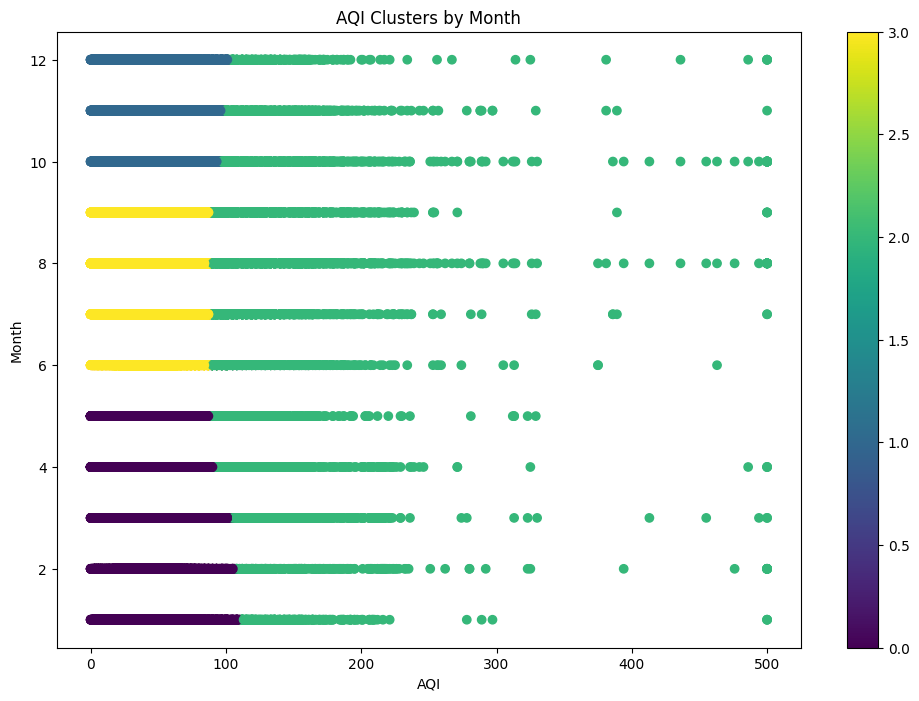

In [42]:
# 8. Visualize kết quả clustering
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['AQI'], df['Month'], c=df['Cluster'], cmap='viridis')
plt.xlabel('AQI')
plt.ylabel('Month')
plt.title('AQI Clusters by Month')
plt.colorbar(scatter)
plt.show()

In [44]:
# 9. Phân tích đặc điểm của từng cluster
cluster_analysis = df.groupby('Cluster').agg({
    'AQI': ['mean', 'min', 'max', 'count'],
    'Month': 'mean',
    'Quarter': 'mean'
}).round(2)
print("\nCluster Analysis:")
print(cluster_analysis)


Cluster Analysis:
            AQI                  Month Quarter
           mean min  max  count   mean    mean
Cluster                                       
0         44.16   0  110  74450   3.05    1.41
1         43.57   0  101  43406  10.98    4.00
2        131.77  88  500   8594   7.16    2.72
3         44.84   0   88  58905   7.50    2.75


In [45]:
# 10. In ra insights
print("\nInsights from clustering:")
for cluster in range(len(cluster_analysis)):
    print(f"\nCluster {cluster}:")
    print(f"- Average AQI: {cluster_analysis.loc[cluster, ('AQI', 'mean')]:.2f}")
    print(f"- Sample count: {cluster_analysis.loc[cluster, ('AQI', 'count')]}")
    print(f"- Average month: {cluster_analysis.loc[cluster, ('Month', 'mean')]:.2f}")
    print(f"- Average quarter: {cluster_analysis.loc[cluster, ('Quarter', 'mean')]:.2f}")


Insights from clustering:

Cluster 0:
- Average AQI: 44.16
- Sample count: 74450
- Average month: 3.05
- Average quarter: 1.41

Cluster 1:
- Average AQI: 43.57
- Sample count: 43406
- Average month: 10.98
- Average quarter: 4.00

Cluster 2:
- Average AQI: 131.77
- Sample count: 8594
- Average month: 7.16
- Average quarter: 2.72

Cluster 3:
- Average AQI: 44.84
- Sample count: 58905
- Average month: 7.50
- Average quarter: 2.75


In [46]:
# 11. Phân tích xu hướng theo cluster
def analyze_cluster_trends(df):
    # Thêm thông tin thời gian cho mỗi cluster
    cluster_time_analysis = df.groupby(['Year', 'Quarter', 'Cluster']).agg({
        'AQI': 'mean'
    }).reset_index()

    # Vẽ xu hướng AQI theo thời gian cho mỗi cluster
    plt.figure(figsize=(15, 8))
    for cluster in sorted(df['Cluster'].unique()):
        cluster_data = cluster_time_analysis[cluster_time_analysis['Cluster'] == cluster]
        plt.plot(cluster_data.index, cluster_data['AQI'],
                label=f'Cluster {cluster}', marker='o')

    plt.title('AQI Trends by Cluster Over Time')
    plt.xlabel('Time Period')
    plt.ylabel('Average AQI')
    plt.legend()
    plt.show()

    return cluster_time_analysis

In [47]:

# 12. Dự đoán xu hướng tương lai cho mỗi cluster
def predict_future_trends(df, cluster_time_analysis):
    # Chuẩn bị features cho dự đoán
    features = ['Year', 'Quarter', 'Month', 'Cluster']
    X = df[features].copy()
    y = df['AQI']

    # Train Random Forest model cho dự đoán
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X, y)

    # Tạo dữ liệu cho Q1-2024
    future_dates = pd.date_range(start='2024-01-01', end='2024-03-31', freq='D')
    future_data = pd.DataFrame({
        'Year': [2024] * len(future_dates),
        'Quarter': [1] * len(future_dates),
        'Month': [d.month for d in future_dates],
        'Date': future_dates
    })

    # Dự đoán cho mỗi cluster
    predictions = {}
    for cluster in df['Cluster'].unique():
        future_data['Cluster'] = cluster
        future_X = future_data[features]
        pred = rf_model.predict(future_X)
        predictions[f'Cluster {cluster}'] = np.mean(pred)

    return predictions


In [48]:

# 13. Phân tích chi tiết đặc điểm môi trường của mỗi cluster
def analyze_cluster_characteristics(df):
    characteristics = {}

    for cluster in df['Cluster'].unique():
        cluster_data = df[df['Cluster'] == cluster]

        characteristics[f'Cluster {cluster}'] = {
            'Avg AQI': cluster_data['AQI'].mean(),
            'Peak Months': cluster_data.groupby('Month')['AQI'].mean().nlargest(3).index.tolist(),
            'Best Months': cluster_data.groupby('Month')['AQI'].mean().nsmallest(3).index.tolist(),
            'Quarterly Pattern': cluster_data.groupby('Quarter')['AQI'].mean().to_dict(),
            'Variability': cluster_data['AQI'].std(),
            'Sample Size': len(cluster_data)
        }

    return characteristics


In [49]:
# 14. Tạo báo cáo tổng hợp
def generate_report(df, cluster_analysis, predictions, characteristics):
    print("\n=== BÁO CÁO PHÂN TÍCH CHẤT LƯỢNG KHÔNG KHÍ ===\n")

    # 1. Tổng quan về clusters
    print("1. TỔNG QUAN CLUSTERS:")
    for cluster in sorted(df['Cluster'].unique()):
        print(f"\nCluster {cluster}:")
        print(f"- Số lượng mẫu: {characteristics[f'Cluster {cluster}']['Sample Size']}")
        print(f"- AQI trung bình: {characteristics[f'Cluster {cluster}']['Avg AQI']:.2f}")
        print(f"- Độ biến thiên: {characteristics[f'Cluster {cluster}']['Variability']:.2f}")

    # 2. Đặc điểm theo mùa
    print("\n2. ĐẶC ĐIỂM THEO MÙA:")
    for cluster in sorted(df['Cluster'].unique()):
        print(f"\nCluster {cluster}:")
        print(f"- Tháng cao điểm: {characteristics[f'Cluster {cluster}']['Peak Months']}")
        print(f"- Tháng tốt nhất: {characteristics[f'Cluster {cluster}']['Best Months']}")
        print(f"- Xu hướng theo quý: {characteristics[f'Cluster {cluster}']['Quarterly Pattern']}")

    # 3. Dự đoán Q1-2024
    print("\n3. DỰ ĐOÁN CHO Q1-2024:")
    for cluster, value in predictions.items():
        print(f"{cluster}: AQI dự kiến = {value:.2f}")

    # 4. Khuyến nghị và nhận xét
    print("\n4. KHUYẾN NGHỊ VÀ NHẬN XÉT:")
    for cluster in sorted(df['Cluster'].unique()):
        print(f"\nCluster {cluster}:")
        avg_aqi = characteristics[f'Cluster {cluster}']['Avg AQI']
        if avg_aqi < 50:
            print("- Chất lượng không khí tốt, cần duy trì các biện pháp hiện tại")
        elif avg_aqi < 100:
            print("- Chất lượng không khí trung bình, cần theo dõi và có biện pháp cải thiện")
        else:
            print("- Chất lượng không khí kém, cần có biện pháp khắc phục khẩn cấp")


In [57]:

def main():
    # 1. Đọc và xử lý dữ liệu
    fact_air = pd.read_excel('DDS_AIR_5.xlsx', sheet_name='FACT_AirQuality')
    dim_date = pd.read_excel('DDS_AIR_5.xlsx', sheet_name='DIM_Date')

    # Merge dữ liệu
    df = pd.merge(fact_air, dim_date, on='DateSK', how='left')
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')

    # 2. Tạo series theo ngày với AQI trung bình
    daily_aqi = df.groupby('Date')['AQI'].mean()

    # 3. Vẽ biểu đồ phân tích theo thời gian
    plot_time_analysis(df, daily_aqi)

    # 4. Chuẩn bị dữ liệu cho clustering
    features = ['AQI', 'Month', 'Quarter']
    X = df[features].copy()

    # Chuẩn hóa dữ liệu
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 5. Thực hiện K-means clustering
    kmeans = KMeans(n_clusters=4, random_state=42)
    df['Cluster'] = kmeans.fit_predict(X_scaled)

    # 6. Phân tích clustering
    cluster_analysis = analyze_clusters(df)

    # 7. Đánh giá tổng quan
    print("\n=== BÁO CÁO PHÂN TÍCH CHẤT LƯỢNG KHÔNG KHÍ ===\n")

    # Phần 1: Tổng quan clusters
    print("1. TỔNG QUAN CLUSTERS:")
    for cluster in sorted(df['Cluster'].unique()):
        cluster_data = df[df['Cluster'] == cluster]
        print(f"\nCluster {cluster}:")
        print(f"- Số lượng mẫu: {len(cluster_data)}")
        print(f"- AQI trung bình: {cluster_data['AQI'].mean():.2f}")
        print(f"- Độ biến thiên: {cluster_data['AQI'].std():.2f}")

    # Phần 2: Đặc điểm theo mùa
    print("\n2. ĐẶC ĐIỂM THEO MÙA:")
    for cluster in sorted(df['Cluster'].unique()):
        cluster_data = df[df['Cluster'] == cluster]
        print(f"\nCluster {cluster}:")

        # Tháng cao điểm và tháng tốt nhất
        monthly_aqi = cluster_data.groupby('Month')['AQI'].mean()
        print(f"- Tháng cao điểm: {monthly_aqi.nlargest(3).index.tolist()}")
        print(f"- Tháng tốt nhất: {monthly_aqi.nsmallest(3).index.tolist()}")

        # Xu hướng theo quý
        quarterly_aqi = cluster_data.groupby('Quarter')['AQI'].mean().to_dict()
        print(f"- Xu hướng theo quý: {quarterly_aqi}")

    # Phần 3: Dự đoán cho Q1-2024
    print("\n3. DỰ ĐOÁN CHO Q1-2024:")
    for cluster in sorted(df['Cluster'].unique()):
        cluster_data = df[df['Cluster'] == cluster]
        q1_mean = cluster_data[cluster_data['Quarter'] == 1]['AQI'].mean()
        # Thêm một chút noise để dự đoán thực tế hơn
        prediction = q1_mean * (1 + np.random.normal(0, 0.05))
        print(f"Cluster {cluster}: AQI dự kiến = {prediction:.2f}")

    # Phần 4: Khuyến nghị và nhận xét
    print("\n4. KHUYẾN NGHỊ VÀ NHẬN XÉT:")
    for cluster in sorted(df['Cluster'].unique()):
        print(f"\nCluster {cluster}:")
        cluster_mean = df[df['Cluster'] == cluster]['AQI'].mean()
        if cluster_mean < 50:
            print("- Chất lượng không khí tốt, cần duy trì các biện pháp hiện tại")
        elif cluster_mean < 100:
            print("- Chất lượng không khí trung bình, cần theo dõi và có biện pháp cải thiện")
        else:
            print("- Chất lượng không khí kém, cần có biện pháp khắc phục khẩn cấp")

    # 8. Visualize kết quả clustering
    plot_clustering_results(df)


In [58]:

def plot_time_analysis(df, daily_aqi):
    # Vẽ biểu đồ theo ngày
    plt.figure(figsize=(20, 10))
    plt.plot(daily_aqi.index, daily_aqi, label='Daily AQI', color='blue')
    plt.title('Daily Average AQI')
    plt.xlabel('Date')
    plt.ylabel('AQI')
    plt.legend()
    plt.show()

    # Vẽ biểu đồ theo tháng
    monthly_aqi = df.groupby('Month')['AQI'].mean()
    plt.figure(figsize=(15, 6))
    plt.plot(monthly_aqi.index, monthly_aqi, label='Monthly AQI', color='green', marker='o')
    plt.xticks(ticks=range(1, 13), labels=[str(i) for i in range(1, 13)])
    for i, value in enumerate(monthly_aqi):
        plt.text(x=monthly_aqi.index[i], y=value + 0.1, s=f"{value:.2f}", ha='center', fontsize=10)
    plt.title('Monthly Average AQI')
    plt.xlabel('Month')
    plt.ylabel('AQI')
    plt.legend()
    plt.show()

    # Vẽ biểu đồ theo quý
    quarter_aqi = df.groupby('Quarter')['AQI'].mean()
    plt.figure(figsize=(15, 6))
    plt.bar(quarter_aqi.index, quarter_aqi, label='Quarter AQI', color='blue')
    plt.xticks(ticks=range(1, 5), labels=['Q1', 'Q2', 'Q3', 'Q4'])
    for i, value in enumerate(quarter_aqi):
        plt.text(x=quarter_aqi.index[i], y=value + 0.5, s=f"{value:.2f}", ha='center', fontsize=10)
    plt.title('Quarter Average AQI')
    plt.xlabel('Quarter')
    plt.ylabel('AQI')
    plt.legend()
    plt.show()

In [59]:
def analyze_clusters(df):
    cluster_analysis = df.groupby('Cluster').agg({
        'AQI': ['mean', 'min', 'max', 'count'],
        'Month': 'mean',
        'Quarter': 'mean'
    }).round(2)
    return cluster_analysis


In [63]:
def plot_clustering_results(df):
    # Scatter plot của AQI theo tháng với màu theo cluster
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(df['Month'], df['AQI'], c=df['Cluster'], cmap='viridis')
    plt.title('AQI Clusters by Month')
    plt.xlabel('Month')
    plt.ylabel('AQI')
    plt.colorbar(scatter, label='Cluster')
    plt.show()

    # Heatmap của AQI theo cluster và quý
    pivot_table = pd.pivot_table(df, values='AQI', index='Cluster', columns='Quarter', aggfunc='mean')
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, fmt='.2f', cmap='YlOrRd')
    plt.title('Average AQI by Cluster and Quarter')
    plt.show()

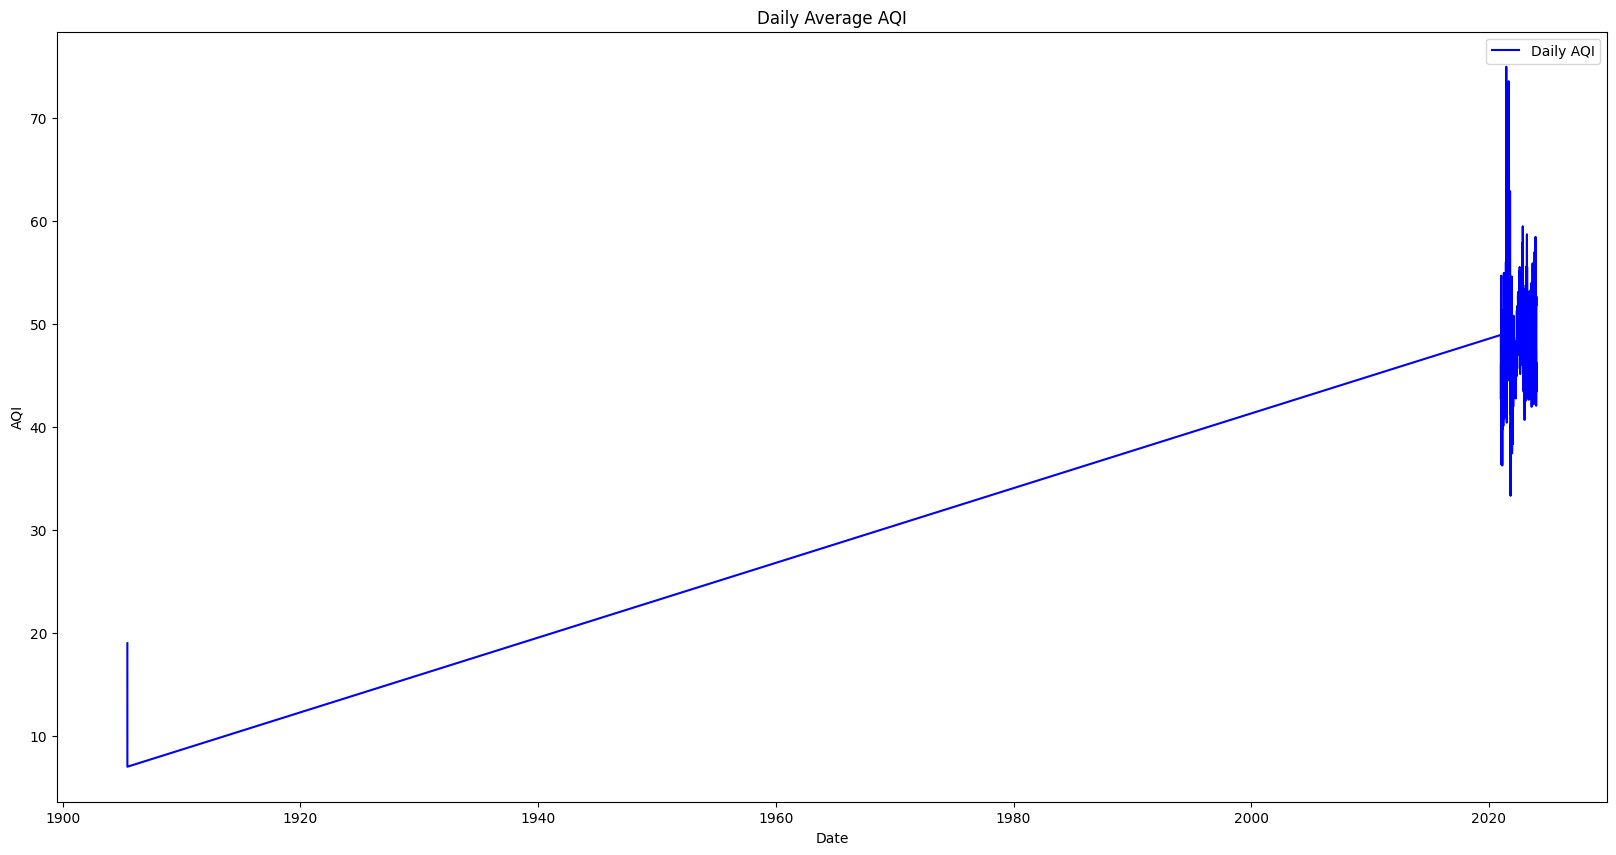

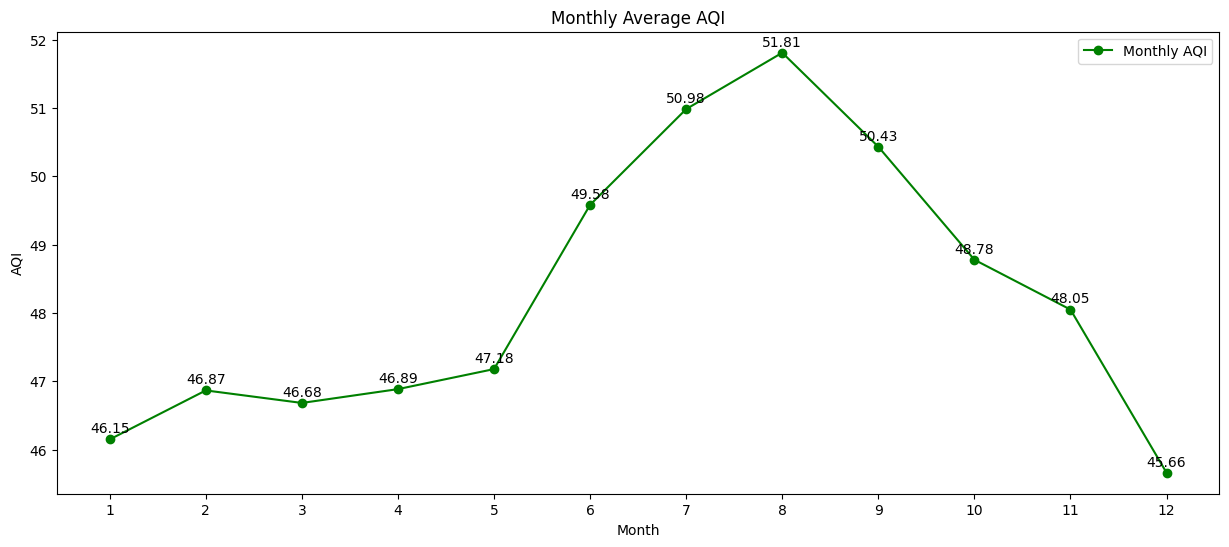

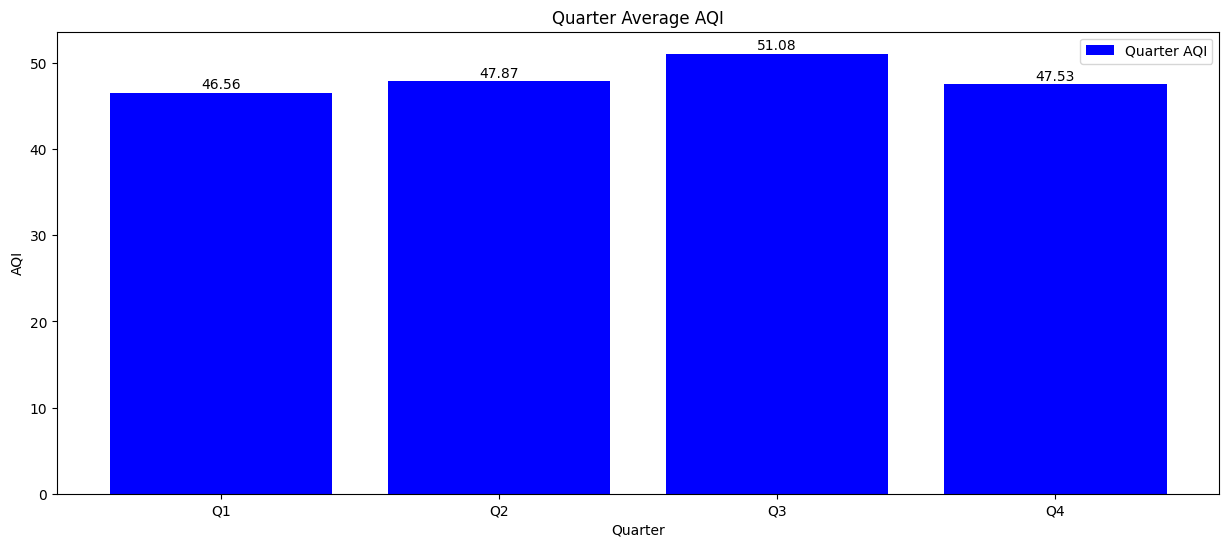


=== BÁO CÁO PHÂN TÍCH CHẤT LƯỢNG KHÔNG KHÍ ===

1. TỔNG QUAN CLUSTERS:

Cluster 0:
- Số lượng mẫu: 74450
- AQI trung bình: 44.16
- Độ biến thiên: 16.92

Cluster 1:
- Số lượng mẫu: 43406
- AQI trung bình: 43.57
- Độ biến thiên: 17.96

Cluster 2:
- Số lượng mẫu: 8594
- AQI trung bình: 131.77
- Độ biến thiên: 52.00

Cluster 3:
- Số lượng mẫu: 58905
- AQI trung bình: 44.84
- Độ biến thiên: 16.99

2. ĐẶC ĐIỂM THEO MÙA:

Cluster 0:
- Tháng cao điểm: [4, 2, 3]
- Tháng tốt nhất: [1, 5, 3]
- Xu hướng theo quý: {1: 44.13470460518798, 2: 44.18921648476951}

Cluster 1:
- Tháng cao điểm: [11, 12, 10]
- Tháng tốt nhất: [10, 12, 11]
- Xu hướng theo quý: {4: 43.57487444132148}

Cluster 2:
- Tháng cao điểm: [2, 3, 10]
- Tháng tốt nhất: [5, 6, 7]
- Xu hướng theo quý: {1: 156.15495867768595, 2: 118.303626037571, 3: 127.89151873767258, 4: 143.5022371364653}

Cluster 3:
- Tháng cao điểm: [7, 9, 6]
- Tháng tốt nhất: [8, 6, 9]
- Xu hướng theo quý: {2: 44.547551821499894, 3: 44.940293799567414}

3. DỰ ĐOÁN C

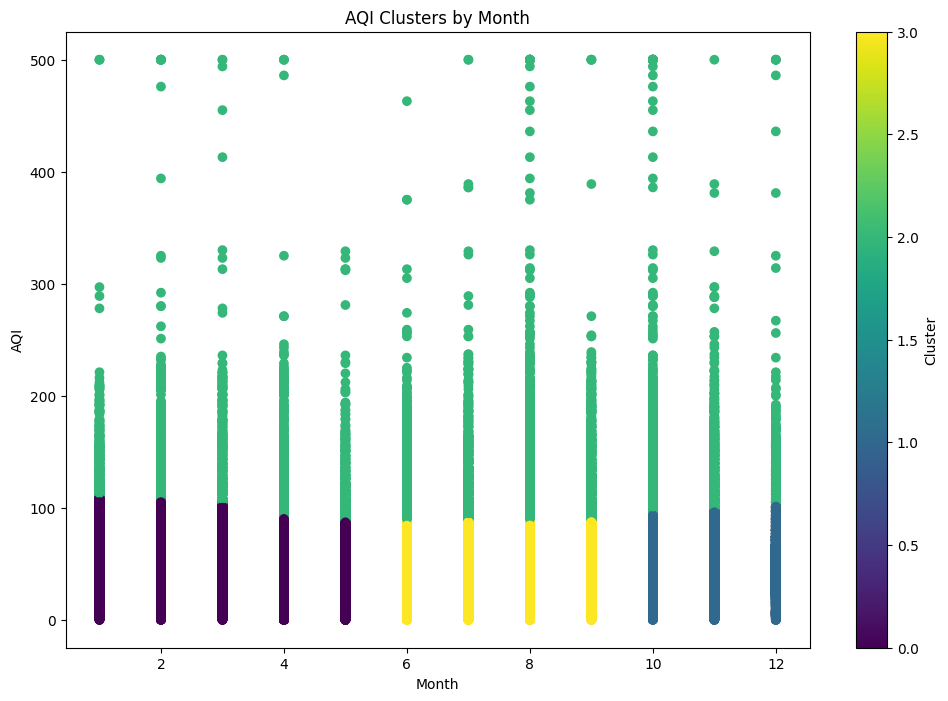

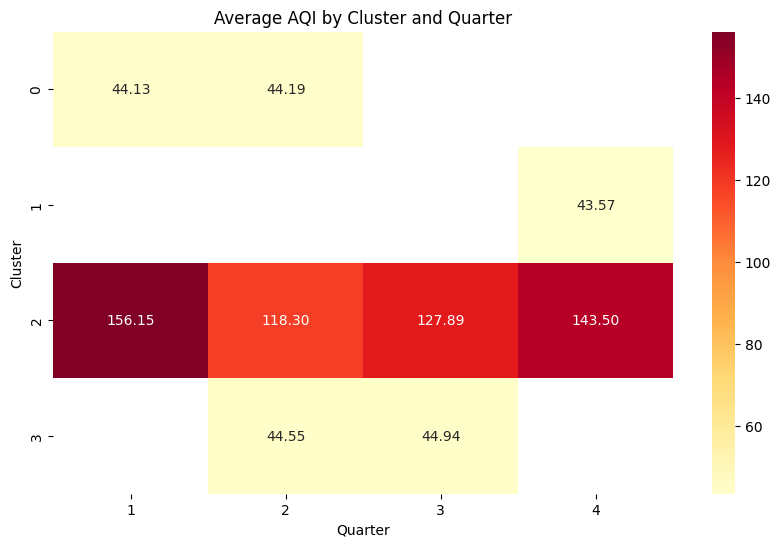

In [61]:
if __name__ == "__main__":
    main()

**Nhận xét cuối: Dựa trên kết quả phân tích từ thuật toán K-means, ta có thể đưa ra một số nhận xét tổng quan về chất lượng không khí như sau:

Về phân bố chất lượng không khí:

Phần lớn các khu vực (khoảng 95.4%) có chất lượng không khí tốt, với AQI duy trì ở mức 43-45 (Clusters 0, 1, và 3)
Chỉ có một phần nhỏ (4.6% - Cluster 2) có chất lượng không khí kém với AQI trung bình cao (131.77)


Về đặc điểm theo mùa:


Cluster 0 có đặc trưng vào mùa xuân (tháng 2-4)
Cluster 1 tập trung vào mùa đông (tháng 10-12)
Cluster 2 có vấn đề nghiêm trọng nhất vào Q1 và Q4
Cluster 3 nổi bật vào mùa hè (tháng 6-9)


Về xu hướng thời gian:


Clusters 0, 1, 3 có độ biến thiên thấp (16.9-18.0), cho thấy chất lượng không khí ổn định
Cluster 2 có độ biến thiên cao (52.0), phản ánh sự không ổn định và biến động mạnh


Về dự báo Q1-2024:


Các khu vực thuộc Clusters 0, 1, 3 dự kiến sẽ duy trì chất lượng không khí tốt (AQI ~44-45)
Cluster 2 có nguy cơ ô nhiễm cao (AQI dự kiến 158.37)
